# Aim 

**We will design a predictive model to predict full-load power output of Combined Cycle Power Plant Dataset from UCI machine learning repository and evaluate the performance of the model.**

**Includes Linear Regression, its assumptions and regularization. Also Random Forest Regressor model.**

https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant

# About Data Set

The dataset contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant.

# Attribute Info

Features consist of hourly average ambient variables:
- Temperature (T) in the range 1.81°C and 37.11°C,
- Ambient Pressure (AP) in the range 992.89-1033.30 milibar,
- Relative Humidity (RH) in the range 25.56% to 100.16%
- Exhaust Vacuum (V) in the range 25.36-81.56 cm Hg

Target is:
- Net hourly electrical energy output (PE) 420.26-495.76 MW

The averages are taken from various sensors located around the plant that record the ambient variables every second. The variables are given without normalization.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge , Lasso
from sklearn.linear_model import RidgeCV
from statsmodels.stats.descriptivestats import Description
from statsmodels.stats.diagnostic import het_goldfeldquandt
from sklearn.preprocessing import FunctionTransformer
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from sklearn.datasets import make_regression
from statsmodels.stats.diagnostic import normal_ad
import statsmodels.api as sm

# Loading Dataset

In [2]:
df=pd.read_excel("Folds5x2_pp.xlsx")
df.head()

,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


In [3]:
df.shape

(9568, 5)

# Summary statistics

In [4]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


# Checking for outliers

<AxesSubplot:>

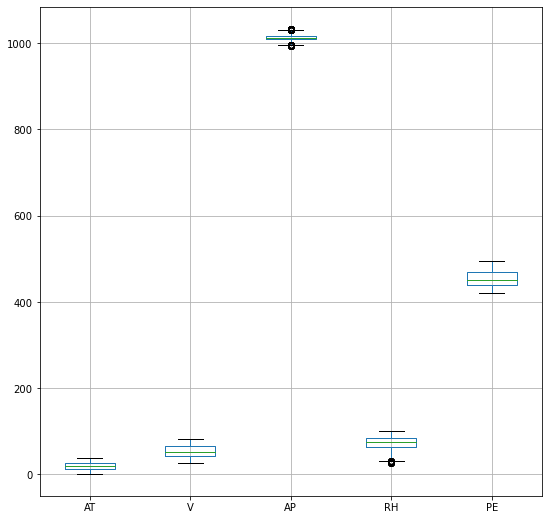

In [5]:
plt.figure(figsize=(9,9))
df.boxplot()

**Closely checking AP and RH as they seem to have outliers in the above graph**

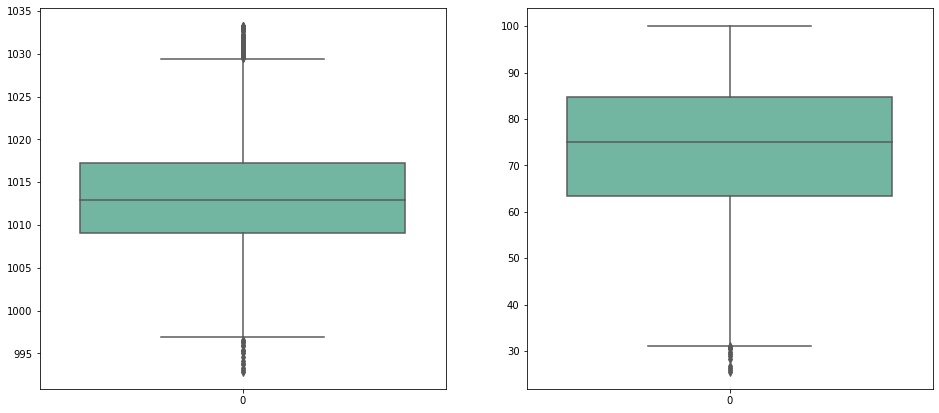

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(16,7))
sns.boxplot(data=df["AP"], orient="v", ax=axes[0], palette="Set2")
sns.boxplot(data=df["RH"], orient="v", ax=axes[1], palette="Set2")
plt.show()

# Checking correlation of features with the target (PE)

[]

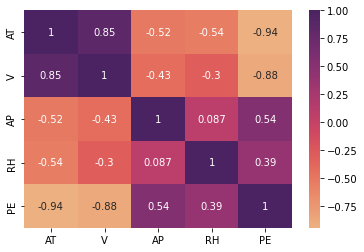

In [7]:
sns.heatmap(df.corr(method="spearman"), annot=True, cmap='flare')
plt.plot()

**We can see that AT and V have a strong negative correlation with the target variable (PE) as their correlation coefficients are -0.94 and -0.88 respectively. AP and RH have a weak positive correlation with PE with correlation coefficients of 0.54 and 0.39.**

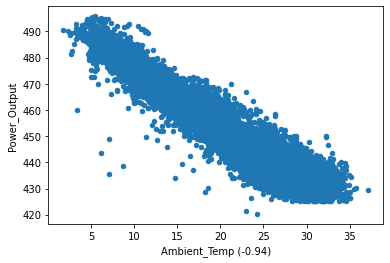

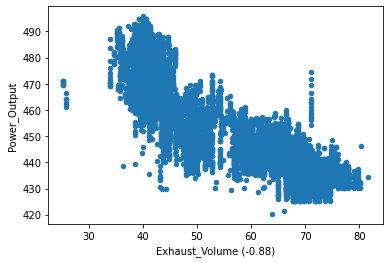

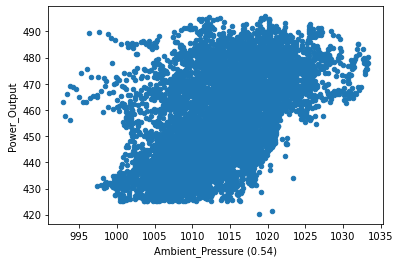

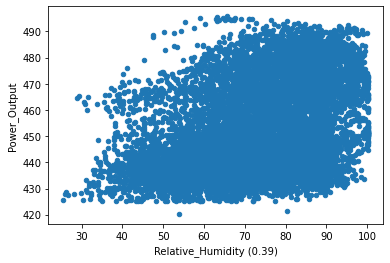

In [8]:
df.plot.scatter(x='AT', y='PE')
plt.xlabel('Ambient_Temp (-0.94)')
plt.ylabel('Power_Output')
plt.show()
 
df.plot.scatter(x='V', y='PE')
plt.xlabel('Exhaust_Volume (-0.88)')
plt.ylabel('Power_Output')
plt.show()
 
df.plot.scatter(x='AP', y='PE')
plt.xlabel('Ambient_Pressure (0.54)')
plt.ylabel('Power_Output')
plt.show()
 
df.plot.scatter(x='RH', y='PE')
plt.xlabel('Relative_Humidity (0.39)')
plt.ylabel('Power_Output')
plt.show()

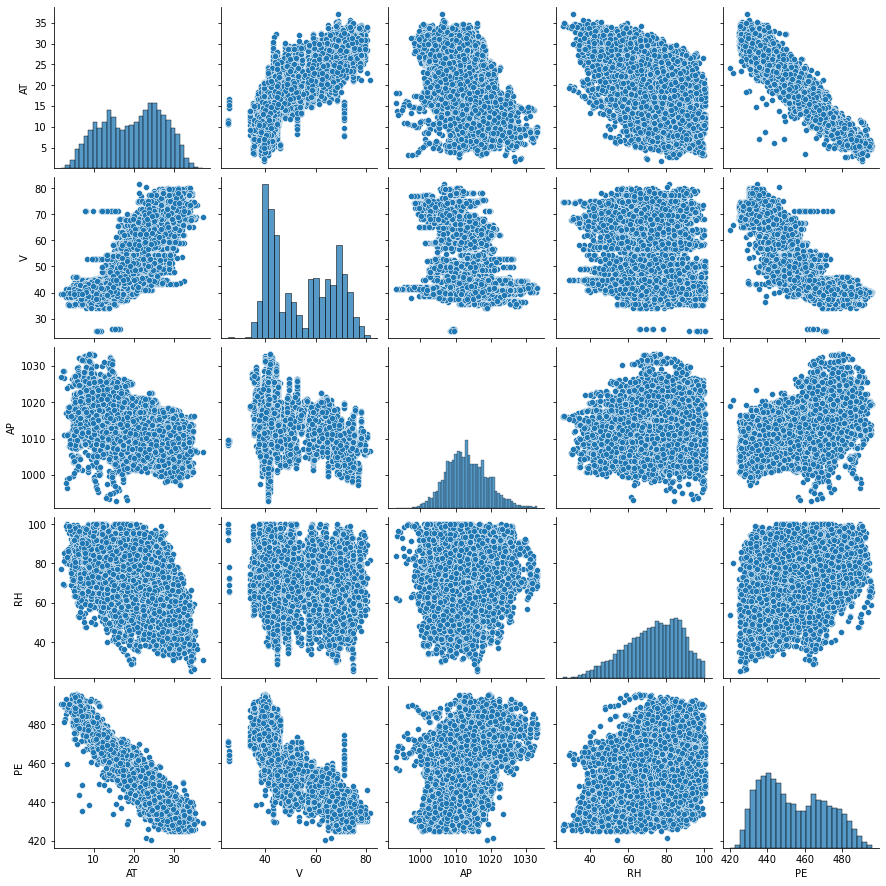

In [9]:
sns.pairplot(df)

<b>Observations:</b>
- Ambient Pressure (AP) is Normally distributed
- Relative Humidity (RH) is Left Skewed
- The attribute scales are different

In [10]:
X=df.iloc[:,0:4] # Feature matrix
y=df.iloc[:,4]  # Target vector

# Assumptions of Linear Regression
https://jeffmacaluso.github.io/post/LinearRegressionAssumptions/

We are creating artificial linear data using the same number of features and observations as the
Combined Cycle Power Plant dataset for assumption test comparison

In [11]:
linear_X, linear_y = make_regression(df.shape[0],X.shape[1],noise=50,random_state=42)

In [12]:
linear_X.shape, linear_y.shape

((9568, 4), (9568,))

In [13]:
X.shape, y.shape

((9568, 4), (9568,))

In [14]:
# Fitting the model for the linear dataset
linear_model = LinearRegression()
linear_model.fit(linear_X, linear_y)

# Returning the R^2 for the model
linear_r2 = linear_model.score(linear_X, linear_y)
print('R^2: {0}'.format(linear_r2))

R^2: 0.8718535790241014


In [15]:
# Fitting the model for CCPP dataset
ccpp_model = LinearRegression()
ccpp_model.fit(X, y)

# Returning the R^2 for the model
ccpp_r2 = ccpp_model.score(X, y)
print('R^2: {0}'.format(ccpp_r2))

R^2: 0.9286960898122536


## Residual plot
We check the residuals of each predictor variable for any pattern that might indicate that a linear model is not appropriate for this dataset.

Text(0, 0.5, 'Residual')

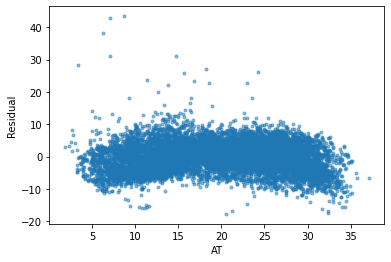

In [16]:
residuals = ccpp_model.predict(X) - df.PE
plt.plot(df.AT, residuals, ".", alpha=0.5)
plt.xlabel("AT")
plt.ylabel("Residual")

Text(0, 0.5, 'Residual')

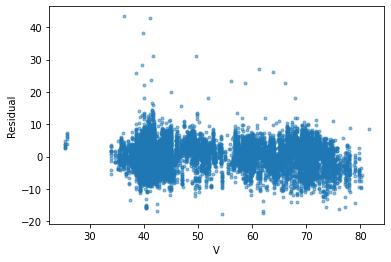

In [17]:
plt.plot(df.V, residuals, ".", alpha=0.5)
plt.xlabel("V")
plt.ylabel("Residual")

Text(0, 0.5, 'Residual')

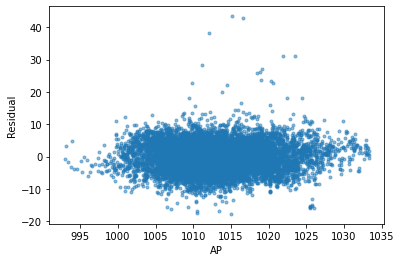

In [18]:
plt.plot(df.AP, residuals, ".", alpha=0.5)
plt.xlabel("AP")
plt.ylabel("Residual")

Text(0, 0.5, 'Residual')

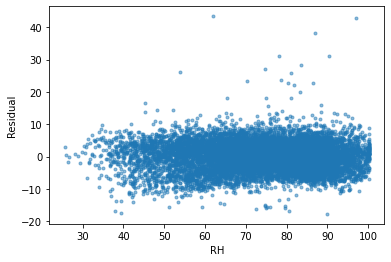

In [19]:
plt.plot(df.RH, residuals, ".", alpha=0.5)
plt.xlabel("RH")
plt.ylabel("Residual")

Observations:

In [20]:
# Creates predictions on the features with the model and calculates residuals
def residual(model,feature,label):
    pred=model.predict(feature)
    df2=pd.DataFrame({"Actual":label,"Predicted":pred})
    df2["Residuals"]=df2["Actual"]-df2["Predicted"]
    return df2

## Test for Linearity

This assumes that there is a linear relationship between the predictors (e.g. independent variables or features) and the response variable (e.g. dependent variable or label). <br>
- Linear regression would not be a fitting estimator if there is no linear relationship between the features and the targets

In [21]:
def linear_assumption(model, features, label):
    print('Linearity Check:', '\n')
        
    print('Checking with a scatter plot of actual vs. predicted.',
           'Predictions should follow the diagonal line.')
    
    # Calculating residuals for the plot
    df_results = residual(model, features, label)
    
    # print(df_results)
    
    # Plotting the actual vs predicted values
    sns.lmplot(x='Actual', y='Predicted', data=df_results, fit_reg=False, height=7)
    # sns.residplot(x="Actual", y="Predicted", data=df_results)    
    # Plotting the diagonal line
    # line_coords = np.arange(df_results.min().min(), df_results.max().max())
    line_coords = np.arange(df_results.iloc[:,0:2].min().min(), df_results.iloc[:,0:2].max().max())
    plt.plot(line_coords, line_coords,  # X and y points
             color='darkorange', linestyle='--')
    plt.title('Actual vs. Predicted')
    plt.show()

We'll start with our linear dataset:

In [22]:
residual(linear_model, linear_X, linear_y)

,Actual,Predicted,Residuals
0,0.269606,23.730296,-23.460691
1,121.310052,137.665333,-16.355281
2,-104.457438,-79.603238,-24.854201
3,150.015510,33.828147,116.187363
4,63.790566,114.527166,-50.736600
...,...,...,...
9563,25.619838,-28.925408,54.545246
9564,183.680479,130.659426,53.021053
9565,-95.899009,-150.390863,54.491854
9566,119.136114,102.937495,16.198620


Linearity Check: 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


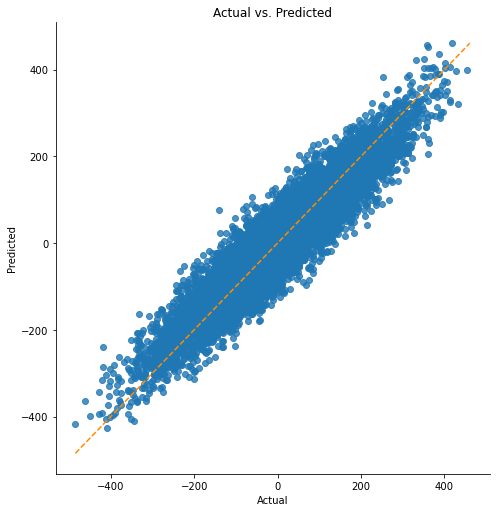

In [23]:
linear_assumption(linear_model, linear_X, linear_y)

As it is a regression dataset, it follows the property of linearity. 

Now, let’s compare it to our CCPP dataset:

In [24]:
residual(ccpp_model, X, y)

,Actual,Predicted,Residuals
0,463.26,467.269790,-4.009790
1,444.37,444.077366,0.292634
2,488.56,483.562643,4.997357
3,446.48,450.555668,-4.075668
4,473.90,471.825499,2.074501
...,...,...,...
9563,460.03,458.630177,1.399823
9564,469.62,472.358625,-2.738625
9565,429.57,432.405798,-2.835798
9566,435.74,443.036676,-7.296676


Linearity Check: 

Checking with a scatter plot of actual vs. predicted. Predictions should follow the diagonal line.


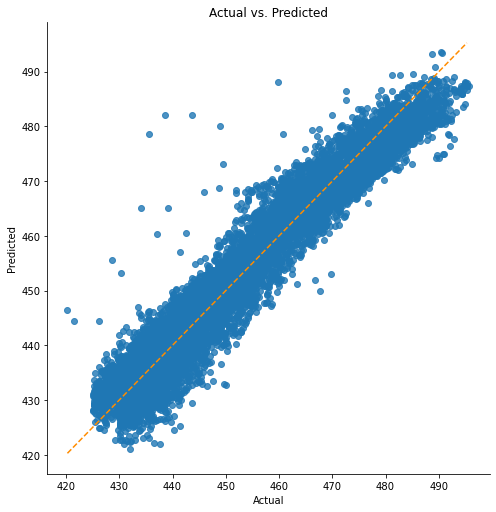

In [25]:
linear_assumption(ccpp_model, X, y)

We can see in this case that there is not a perfect linear relationship. Our predictions are biased towards higher values for around 420-460. <br><br>
**How to solve this problem:** 
- Apply polynomial regression
- Apply normalization

## Test for Normality
Assumes that the error terms are normally distributed. If they are not, nonlinear transformations of variables may solve this.
- This assumption being violated primarily causes issues with the confidence intervals
- More specifically, this assumes that the error terms of the model are normally distributed. 

<b>It can happen:</b> 
- If either the predictors or the label are significantly non-normal 
- Linearity assumption being violated or 
- Outliers affecting our model
<br>

<b>How to detect it: </b>
- Using Shapiro-Wilk test
- Looking at both the histogram and the p-value from the Anderson-Darling test for normality <br>

### Perform Shapiro-Wilk test
This function produces a test statistic W along with a corresponding p-value. 
- If the p-value is less than α =.05, there is sufficient evidence to say that the sample does not come from a population that is normally distributed.

In [26]:
print("Shapiro test for linear dataset", shapiro(linear_X))
print("Shapiro test for CCPP dataset", shapiro(X))

Shapiro test for linear dataset ShapiroResult(statistic=0.9999750256538391, pvalue=0.9965659976005554)
Shapiro test for CCPP dataset ShapiroResult(statistic=0.5875012874603271, pvalue=0.0)


/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Observations: 
- The p-value of the first test turns out to be 0.99. Since this value is not less than .05, we can assume the sample data comes from a population that is normally distributed.

Note: The sample size must be between 3 and 5,000 in order to use the shapiro.test() function.
p-value may not be accurate for N > 5000

### Perform Anderson-Darling test

In [27]:
def normal_errors_assumption(model, features, label, p_value_thresh=0.05):
    
    print('Normality Check:', '\n')
    
    # Calculating residuals for the Anderson-Darling test
    df_results = residual(model, features, label)
    
    print('Using the Anderson-Darling test for normal distribution')

    # Performing the test on the residuals
    p_value = normal_ad(df_results['Residuals'])[1]
    print('p-value from the test - below 0.05 generally means non-normal:', p_value)
    
    # Reporting the normality of the residuals
    if p_value < p_value_thresh:
        print('Residuals are not normally distributed')
    else:
        print('Residuals are normally distributed')
    
    # Plotting the residuals distribution
    plt.title('Distribution of Residuals')
    sns.distplot(df_results['Residuals'])
    plt.show()
    
    print()
    if p_value > p_value_thresh:
        print('Normally distributed')
    else:
        print('Not Normally distributed')
        print('Confidence intervals will likely be affected')
        print('Try performing nonlinear transformations on variables')

As with our previous assumption, we’ll start with the linear dataset:

Normality Check: 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.9220047242470982
Residuals are normally distributed


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


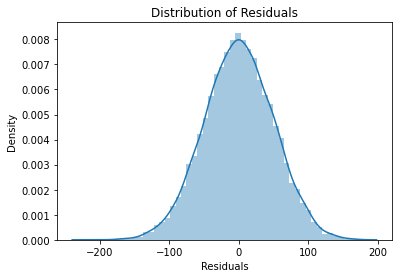


Normally distributed


In [28]:
normal_errors_assumption(linear_model, linear_X, linear_y)

Now let’s run the same test on the CCPP dataset:

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Normality Check: 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 2.585224173208246e-22
Residuals are not normally distributed


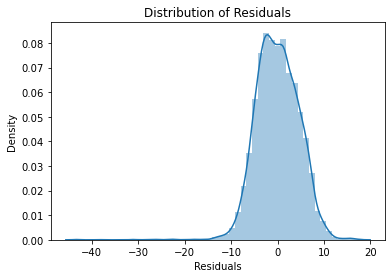


Not Normally distributed
Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [29]:
normal_errors_assumption(ccpp_model, X, y)

**How to solve it:**
- Remove the outlieers
- Apply non linear transformation

Normality Check: 

Using the Anderson-Darling test for normal distribution
p-value from the test - below 0.05 generally means non-normal: 0.0
Residuals are not normally distributed


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


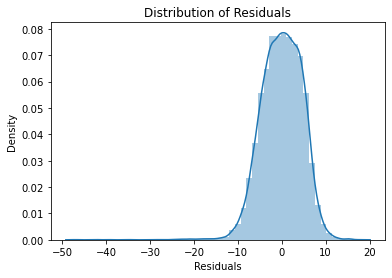


Not Normally distributed
Confidence intervals will likely be affected
Try performing nonlinear transformations on variables


In [30]:
transformer = FunctionTransformer(np.log1p)
X=transformer.transform(X)
lr_transform = LinearRegression()
lr_transform.fit(X,y)
normal_errors_assumption(lr_transform,X,y)

After doing log transformation, still it's not normally distributed, but far more better than the previous one

If a given dataset is not normally distributed, we can often perform one of the following transformations to make it more normal:

1. Log Transformation: Transform the response variable from y to log(y).

2. Square Root Transformation: Transform the response variable from y to √y.

3. Cube Root Transformation: Transform the response variable from y to y1/3.

By performing these transformations, the response variable typically becomes closer to normally distributed.

## Test for Multicolinearity
This assumes that the predictors used in the regression are not correlated with each other. 
<br><br>
<b>How to solve it: </b>
- This can be fixed by other removing predictors with a high variance inflation factor (VIF) 
- Performing dimensionality reduction

In [31]:
def multicollinearity_assumption(model, features, label, feature_names=None):
    print('Multicolinearity Check:')
        
    # Plotting the heatmap

    sns.heatmap(pd.DataFrame(features, columns=feature_names).corr(), annot=True)
    plt.title('Correlation of Variables')
    plt.show()
        
    print('Variance Inflation Factors (VIF)')
    print('> 10: An indication that multicollinearity may be present')
    print('> 100: Certain multicollinearity among the variables')
    print('-------------------------------------')
       
    # Gathering the VIF for each variable
    VIF = [variance_inflation_factor(features, i) for i in range(features.shape[1])]
    for idx, vif in enumerate(VIF):
        print('{0}: {1}'.format(feature_names[idx], vif))
        
    # Gathering and printing total cases of possible or definite multicollinearity
    possible_multicollinearity = sum([1 for vif in VIF if vif > 10])
    definite_multicollinearity = sum([1 for vif in VIF if vif > 100])
    print()
    print('{0} cases of possible multicollinearity'.format(possible_multicollinearity))
    print('{0} cases of definite multicollinearity'.format(definite_multicollinearity))
    print()

    if definite_multicollinearity == 0:
        if possible_multicollinearity == 0:
            print('Predictors are not correlated with each other')
        else:
            print('Some Predictors may be correlated with each other')
            print()
            print('Consider removing variables with a high Variance Inflation Factor (VIF)')

    else:
        print('Predictors are correlated with each other')
        print()
        print('Consider removing variables with a high Variance Inflation Factor (VIF)')

Starting with the linear dataset:

In [32]:
name = ["x"+str(i+1)for i in range(linear_X.shape[1])]
name

['x1', 'x2', 'x3', 'x4']

Multicolinearity Check:


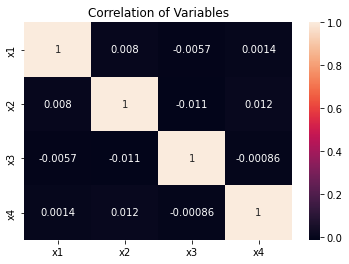

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
x1: 1.0000965414593637
x2: 1.000324682673306
x3: 1.0001612241015272
x4: 1.0001373538053737

0 cases of possible multicollinearity
0 cases of definite multicollinearity

Predictors are not correlated with each other


In [33]:
multicollinearity_assumption(linear_model, linear_X, linear_y, name)

Multicolinearity Check:


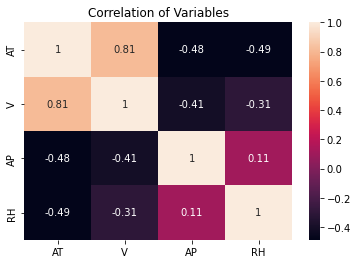

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
AT: 178.43666760829936
V: 904.3010851311749
AP: 990.0641449514949
RH: 534.1091044181178

4 cases of possible multicollinearity
4 cases of definite multicollinearity

Predictors are correlated with each other

Consider removing variables with a high Variance Inflation Factor (VIF)


In [34]:
multicollinearity_assumption(ccpp_model, X, y, X.columns)

<b>There is multicollinearity for all of the variables in this dataset.</b>

In [35]:
X2=sm.add_constant(df[["AT", "V", "AP", "RH"]])
model1 = sm.OLS(df["PE"], X2 )
mod_fit = model1.fit()
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.929
Method:                 Least Squares   F-statistic:                 3.114e+04
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:59:25   Log-Likelihood:                -28088.
No. Observations:                9568   AIC:                         5.619e+04
Df Residuals:                    9563   BIC:                         5.622e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        454.6093      9.749     46.634      0.000     435.500     473.718
AT            -1.9775      0.015   -129.342      0.000      -2.007      -1.948
V             -0.2339      0.007    -32.122      0.000      -0.248      -0.220
AP             0.0621      0.009      6.564      0.000       0.044       0.081
RH            -0.1581      0.004    -37.918      0.000      -0.166      -0.150
==============================================================================
Omnibus:                      892.002   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4086.777
Skew:                          -0.352   Prob(JB):                         0.00
Kurtosis:                       6.123   Cond. No.                     2.13e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.13e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
X_updated = sm.add_constant(df[["AT", "V", "RH"]])
model1 = sm.OLS(df["PE"], X_updated )
mod_fit = model1.fit()
mod_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     PE   R-squared:                       0.928
Model:                            OLS   Adj. R-squared:                  0.928
Method:                 Least Squares   F-statistic:                 4.132e+04
Date:                Tue, 21 Dec 2021   Prob (F-statistic):               0.00
Time:                        02:59:25   Log-Likelihood:                -28110.
No. Observations:                9568   AIC:                         5.623e+04
Df Residuals:                    9564   BIC:                         5.626e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        518.5489      0.388   1337.310      0.000     517.789     519.309
AT            -2.0187      0.014   -144.495      0.000      -2.046      -1.991
V             -0.2281      0.007    -31.491      0.000      -0.242      -0.214
RH            -0.1654      0.004    -41.092      0.000      -0.173      -0.157
==============================================================================
Omnibus:                      901.476   Durbin-Watson:                   2.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4143.993
Skew:                          -0.357   Prob(JB):                         0.00
Kurtosis:                       6.144   Cond. No.                         781.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
# Removing AP because of High Variance Inflation Factor
X2 = df[['AT', 'V', 'RH']]
X2

,AT,V,RH
0,14.96,41.76,73.17
1,25.18,62.96,59.08
2,5.11,39.40,92.14
3,20.86,57.32,76.64
4,10.82,37.50,96.62
...,...,...,...
9563,16.65,49.69,91.00
9564,13.19,39.18,66.78
9565,31.32,74.33,36.48
9566,24.48,69.45,62.39


In [38]:
# Fitting the model for CCPP_updated dataset
ccpp_model_updated = LinearRegression()
ccpp_model_updated.fit(X2, y)
# Returning the R^2 for the model
ccpp_r2_updated = ccpp_model_updated.score(X2, y)
print('R^2: {0}'.format(ccpp_r2_updated))

R^2: 0.928374821658302


Multicolinearity Check:


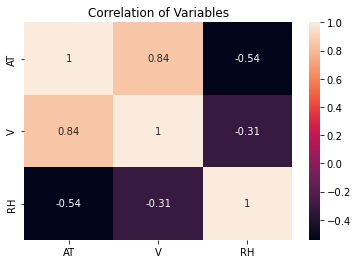

Variance Inflation Factors (VIF)
> 10: An indication that multicollinearity may be present
> 100: Certain multicollinearity among the variables
-------------------------------------
AT: 36.708794644133185
V: 72.69202443156571
RH: 13.567741744481193

3 cases of possible multicollinearity
0 cases of definite multicollinearity

Some Predictors may be correlated with each other

Consider removing variables with a high Variance Inflation Factor (VIF)


In [39]:
multicollinearity_assumption(ccpp_model_updated, X2, y, X2.columns)

## Test for Homoscedasticity

This assumes homoscedasticity, which is the same variance within the error terms. 
Heteroscedasticity, the violation of homoscedasticity, occurs when we don’t have an even variance across the error terms.<br>

<b>What it will affect: </b>
- Significance tests for coefficients due to the standard errors being biased. 
- Additionally, the confidence intervals will be either too wide or too narrow.<br>

<b>How to check it: </b>
- Plot the residuals and see if the variance appears to be uniform.

### Using Residual Plot

In [40]:
def homoscedasticity_assumption(model, features, label):
    print('Homoscedasticity Check:', '\n')
    
    print('Residuals should have relative constant variance')
        
    # Calculating residuals for the plot
    df_results = residual(model, features, label)

    # Plotting the residuals
    sns.residplot(x=df_results.index,y=df_results.Residuals)
    
    plt.title('Residuals')
    plt.show()  

Plotting the residuals of our ideal dataset:

Homoscedasticity Check: 

Residuals should have relative constant variance


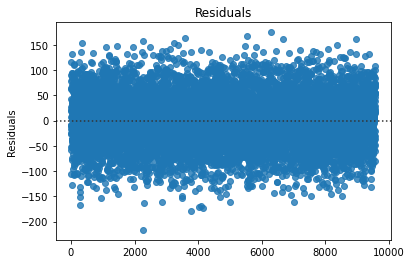

In [41]:
homoscedasticity_assumption(linear_model, linear_X, linear_y)

Next, looking at the residuals of the CCPP dataset:

Homoscedasticity Check: 

Residuals should have relative constant variance


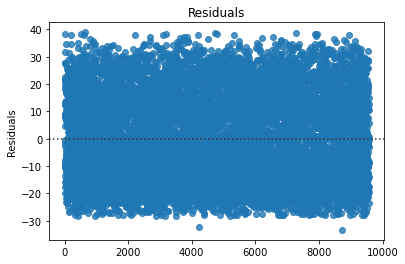

In [42]:
homoscedasticity_assumption(ccpp_model, X, y)

Here, both plot follows the criteria of Homoscedasticy. 

In [43]:
residual_normal=residual(ccpp_model,X,y)
residual_normal

,Actual,Predicted,Residuals
0,463.26,448.002650,15.257350
1,444.37,446.962825,-2.592825
2,488.56,449.877935,38.682065
3,446.48,447.299914,-0.819914
4,473.90,448.576704,25.323296
...,...,...,...
9563,460.03,447.729156,12.300844
9564,469.62,448.263875,21.356125
9565,429.57,446.582055,-17.012055
9566,435.74,446.984960,-11.244960


### Using The Goldfeld-Quandt test

The Goldfeld-Quandt test uses the following null and alternative hypotheses:

<b>Null (H0): </b>Homoscedasticity is present.

<b>Alternative (HA): </b>Heteroscedasticity is present.

<b>How to fix this issue:</b>

1. Transform the response variable.

You can try performing a transformation on the response variable, such as taking the log, square root, or cube root of the response variable. Typically this can cause heteroscedasticity to go away.

2. Use weighted regression.

Weighted regression assigns a weight to each data point based on the variance of its fitted value. Essentially, this gives small weights to data points that have higher variances, which shrinks their squared residuals.

When the proper weights are used, weighted regression can eliminate the problem of heteroscedasticity.

For linear dataset:

In [44]:
f_val,p_val,ordering=het_goldfeldquandt(linear_y, linear_X)
print(p_val)
if p_val>0.05:
    print("HO: Homoscedasticity is present ")
else:
    print("HA: Heteroscedasticity is present")

0.9292825979335135
HO: Homoscedasticity is present 


For CCPP dataset:

In [45]:
f_val,p_val,ordering=het_goldfeldquandt(y,X)
print(p_val)
if p_val>0.05:
    print("HO: Homoscedasticity is present ")
else:
    print("HA: Heteroscedasticity is present")

0.10920149040801139
HO: Homoscedasticity is present 


## Test for Autocorrelation
This assumes no autocorrelation of the error terms. Autocorrelation being present typically indicates that we are missing some information that should be captured by the model. <br>

<b>Why it can happen: </b>In a time series scenario, there could be information about the past that we aren’t capturing. In a non-time series scenario, our model could be systematically biased by either under or over predicting in certain conditions. Lastly, this could be a result of a violation of the linearity assumption.<br>

<b>How to detect it: </b>
- We will perform a Durbin-Watson test to determine if either positive or negative correlation is present. 
- Alternatively, you could create plots of residual autocorrelations. <br>

<b>How to fix it: </b>
- A simple fix of adding lag variables can fix this problem. 
- Alternatively, interaction terms, additional variables, or additional transformations may fix this.

### Using Durbin-Watson test

https://www.statology.org/durbin-watson-test/

The test statistic always ranges from 0 to 4 where:

- 1.5 < d < 2.5 is no autocorrelation
- 1.5 < is positive autocorrelation
- <p>> 2.5 is negative autocorrelation </p>

In general, if d is less than 1.5 or greater than 2.5 then there is potentially a serious autocorrelation problem. Otherwise, if d is between 1.5 and 2.5 then autocorrelation is likely not a cause for concern.

In [46]:
def autocorrelation_assumption(model, features, label):
    from statsmodels.stats.stattools import durbin_watson
    print('Autocorrelation Check:', '\n')
    
    # Calculating residuals for the Durbin Watson-tests
    df_results = residual(model, features, label)

    durbinWatson = durbin_watson(df_results['Residuals'])
    print('Durbin-Watson:', durbinWatson)
    if durbinWatson < 1.5:
        print('Signs of positive autocorrelation', '\n')
    elif durbinWatson > 2.5:
        print('Signs of negative autocorrelation', '\n')
    else:
        print('Little to no autocorrelation', '\n')

Testing with our ideal dataset:

In [47]:
autocorrelation_assumption(linear_model, linear_X, linear_y)

Autocorrelation Check: 

Durbin-Watson: 1.961970769250458
Little to no autocorrelation 



With CCPP dataset:

In [48]:
autocorrelation_assumption(ccpp_model, X, y)

Autocorrelation Check: 

Durbin-Watson: 1.7127327628964883
Little to no autocorrelation 



# Splitting train and test set: (80-20)

In [49]:
X_train,X_test,y_train,y_test=model_selection.train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7654, 4)
(1914, 4)
(7654,)
(1914,)


# Fitting linear model

In [50]:
lr=LinearRegression()
lr_model=lr.fit(X_train,y_train)
pred=lr.predict(X_test)
print(pred)
print(lr_model.coef_)
print(lr_model.intercept_)

[451.15193151 428.80630925 444.10313951 ... 453.3784673  482.15159464
 436.66752741]
[-26.93212089 -23.63769566 203.34530935  -3.76134985]
-763.3877787115621


In [51]:
print(f"training score--->{lr_model.score(X_train,y_train)}")
print(f"testing score--->{lr_model.score(X_test,y_test)}")

training score--->0.9255996933247533
testing score--->0.9303139536327995


# Regularization

## Standarization using preprocessing.StandardScaler()

In [52]:
# we need to scale the data
sc=StandardScaler()
sc.fit(X_train)
X_scaled_train=sc.transform(X_train)
X_scaled_test=sc.transform(X_test)

### Ridge regularization on scaled dataset

In [53]:
ridge=Ridge()
ridge.fit(X_scaled_train,y_train)
print(f"training score --->{ridge.score(X_scaled_train,y_train)}")
print(f"testing score --->{ridge.score(X_scaled_test,y_test)}")

training score --->0.9255996768087464
testing score --->0.9303138551800151


In [54]:
alpha=[0.1,0.01,0.001,0.5,1,10,100,1000]
for i in alpha:
    ridge=Ridge(alpha=i)
    ridge.fit(X_scaled_train,y_train)
    print(f"training score --->{ridge.score(X_scaled_train,y_train)}")
    print(f"testing score --->{ridge.score(X_scaled_test,y_test)}")
    print("----------------------")

training score --->0.925599693159409
testing score --->0.930313945185147
----------------------
training score --->0.9255996933230997
testing score --->0.9303139528020278
----------------------
training score --->0.9255996933247368
testing score --->0.9303139535498622
----------------------
training score --->0.9255996891931948
testing score --->0.9303139082867551
----------------------
training score --->0.9255996768087464
testing score --->0.9303138551800151
----------------------
training score --->0.9255980599257922
testing score --->0.9303115886241777
----------------------
training score --->0.9254526111649772
testing score --->0.9301675324074252
----------------------
training score --->0.9181535253377333
testing score --->0.9232566548106346
----------------------


In [55]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", StandardScaler()), ("ridge", Ridge())])

In [56]:
alpha=[0.001,0.01,0.1,1,10,100,1000]
for i in alpha:
    pipe = Pipeline([("scaler", StandardScaler()), 
                     ("ridge", Ridge(alpha=i))])
    pipe.fit(X_train,y_train)
    print(f"training score --->{pipe.score(X_train,y_train)}")
    print(f"testing score --->{pipe.score(X_test,y_test)}")
    print("----------------------")

training score --->0.9255996933247368
testing score --->0.9303139535498622
----------------------
training score --->0.9255996933230997
testing score --->0.9303139528020278
----------------------
training score --->0.925599693159409
testing score --->0.930313945185147
----------------------
training score --->0.9255996768087464
testing score --->0.9303138551800151
----------------------
training score --->0.9255980599257922
testing score --->0.9303115886241777
----------------------
training score --->0.9254526111649772
testing score --->0.9301675324074252
----------------------
training score --->0.9181535253377333
testing score --->0.9232566548106346
----------------------


**We see the accuracy is around 92%. So, we try to preprocess dataset using normalize() this time.**

## Normalization using preprocessing.normalize()

,AT,V,AP,RH,PE
AT,1.000000,0.853046,0.940404,-0.507330,-0.932134
V,0.853046,1.000000,0.827891,-0.284977,-0.880354
AP,0.940404,0.827891,1.000000,-0.490010,-0.983720
RH,-0.507330,-0.284977,-0.490010,1.000000,0.345422
PE,-0.932134,-0.880354,-0.983720,0.345422,1.000000


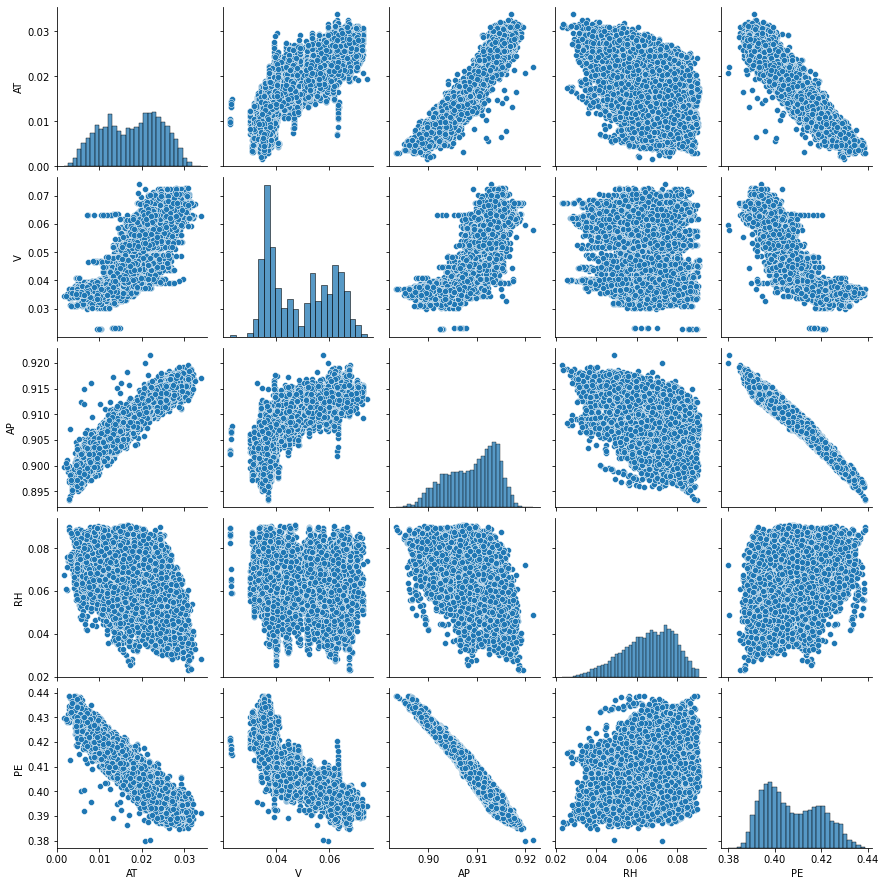

In [57]:
#normalizing the data:
df_nor=preprocessing.normalize(df)
df_nor=pd.DataFrame(df_nor)
df_nor.columns = df.columns
sns.pairplot(df_nor)
df_nor.corr()

In [59]:
X_nor=df_nor.iloc[:,0:4]
y_nor=df_nor.iloc[:,4]

## Splitting train-test set on dataset after preprocessing.normalize

In [60]:
X_nor_train,X_nor_test,y_nor_train,y_nor_test=model_selection.train_test_split(X_nor,y_nor,test_size=0.2)
print(X_nor_train.shape)
print(X_nor_test.shape)
print(y_nor_train.shape)
print(y_nor_test.shape)

(7654, 4)
(1914, 4)
(7654,)
(1914,)


## Fitting linear model on dataset after preprocessing.normalize

In [61]:
lr_nor=LinearRegression()
lr_nor_model=lr_nor.fit(X_nor_train,y_nor_train)
pred=lr_nor.predict(X_nor_test)
print(pred)
print(lr_nor_model.coef_)
print(lr_nor_model.intercept_)

[0.40709778 0.41756546 0.40590067 ... 0.41736137 0.4309386  0.40016886]
[-0.06090733 -0.14110467 -2.14298391 -0.14787917]
2.373309536153739


In [62]:
print(f"training score--->{lr_nor_model.score(X_nor_train,y_nor_train)}")
print(f"testing score--->{lr_nor_model.score(X_nor_test,y_nor_test)}")

training score--->0.9989806795209667
testing score--->0.9990661918697007


# Checking Accuracy using different methods

## 1. Root Mean Squared Error (RMSE) 

It measures the average error performed by the model in predicting the outcome for an observation.

**The lower the RMSE score the better**

In [63]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_nor_test, pred)
rmse = np.sqrt(mse)
rmse

0.0003709916378487344

## 2. R-Squared

It means how much of the variation in the target variable that can be explained by the set of features used in training the model.

**The higher the R-squared score the better**

In [64]:
from sklearn.metrics import r2_score
r_squared = r2_score(y_nor_test, pred)
r_squared

0.9990661918697007

## 3. Mean Absolute Error

It measures how far predicted values are away from the actual values.

**The lower the MAE value the better**

In [65]:
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_nor_test, pred)
mae

0.0002907224639359084

# Other Model

## Random Forest Regressor

### using original dataset

In [66]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor= RandomForestRegressor()
rf_regressor.fit(X_train, y_train)
y_pred = rf_regressor.predict(X_test)

In [67]:
print(f"training score--->{rf_regressor.score(X_train,y_train)}")
print(f"testing score--->{rf_regressor.score(X_test,y_test)}")

training score--->0.9945876629711117
testing score--->0.9613532180556639


### using dataset after preprocessing.normalize

In [68]:
rf_regressor_nor= RandomForestRegressor()
rf_regressor_nor.fit(X_nor_train, y_nor_train)
y_pred_nor = rf_regressor_nor.predict(X_nor_test)

In [69]:
print(f"training score--->{rf_regressor_nor.score(X_nor_train,y_nor_train)}")
print(f"testing score--->{rf_regressor_nor.score(X_nor_test,y_nor_test)}")

training score--->0.9999126828904181
testing score--->0.9994984317301607


# Conclusion

* We check for the linearity of our dataset using residual plots, and found our dataset almost linear
* We use Shapiro-Wilk and Anderson-Darling test, to check whether our dataset is normally distributed or not
* Check for the multicolinearity and try to improve our dataset so that there is no effect of multicolinearity
* We also test for homoscedasticity and it's present in the dataset
* Using Durbin-Watson test, we check for the autocorrelation of our dataset
* There is high negative correlation between AP, V, AT features with Power Output
* We also see the predictor features (AT and V) are highly correlated to each other
* We don't see any change in the accuracy of linear regression model after using  ridge regularization
* Accuracy of linear regression model increased from 92% to 99% after preprocessing.normalize()
* Accuracy of random forest regressor model has increaded from 96% to 99% after preprocessing using normalize